In [9]:
!pip install kaggle Pillow imageio matplotlib pandas torchsummary
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download xhlulu/140k-real-and-fake-faces

import shutil
shutil.unpack_archive('140k-real-and-fake-faces.zip')

Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
100% 3.74G/3.75G [00:52<00:00, 168MB/s]
100% 3.75G/3.75G [00:52<00:00, 77.0MB/s]


In [4]:
import os
import numpy as np
import datetime
from copy import deepcopy
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision.utils import save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchsummary import summary

device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
# Parameters
device = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 256
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
FEATURES_CRITIC = 64
FEATURES_GEN = 64

In [24]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 2, 1, 0),  # img: 2x2
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 4x4
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 8x8
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 16x16
            self._block(features_g * 2, features_g, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN)
gen.to(device)
gen.load_state_dict(torch.load("generator.pth", weights_only=True))
gen.eval()

Generator(
  (net): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(2, 2), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): Sequential(
      (0): C

In [5]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            self._block(features_d * 8, features_d * 16, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 16, 1, kernel_size=2, stride=1, padding=0),
            nn.Flatten(),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC).to(device)
summary(critic, ( 3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,136
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
    InstanceNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
    InstanceNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
   InstanceNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12           [-1, 1024, 2, 2]       8,388,608
   InstanceNorm2d-13           [-1, 1024, 2, 2]           2,048
        LeakyReLU-14           [-1, 102

In [11]:
data_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * CHANNELS_IMG, [0.5] * CHANNELS_IMG),
])

dataset = datasets.ImageFolder(root="real_vs_fake/real-vs-fake/test", transform=data_transforms)
real_class_idx = dataset.class_to_idx["real"]
fake_class_idx = dataset.class_to_idx["fake"]
real_indices = [i for i, label in enumerate(dataset.targets) if label==real_class_idx]
fake_indices = [i for i, label in enumerate(dataset.targets) if label==fake_class_idx]
# real_subset_indices = random.sample(real_indices, 2500)
# fake_subset_indices = random.sample(fake_indices, 2500)
# subset_indices = real_subset_indices + fake_subset_indices
real_subset = Subset(dataset, real_indices)
fake_subset = Subset(dataset, fake_indices)
# test_loader = DataLoader(subset_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
real_loader = DataLoader(real_subset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
fake_loader = DataLoader(fake_subset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
print("No. of testing images: ", len(dataset))

No. of testing images:  20000


In [18]:
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC).to(device)
critic.load_state_dict(torch.load("critic_retrained.pth", weights_only=True))
critic.eval()

<All keys matched successfully>

torch.Size([3, 64, 64])
True label: tensor(1)
Predicted label: tensor(0.9999, device='cuda:0', grad_fn=<SqueezeBackward0>)


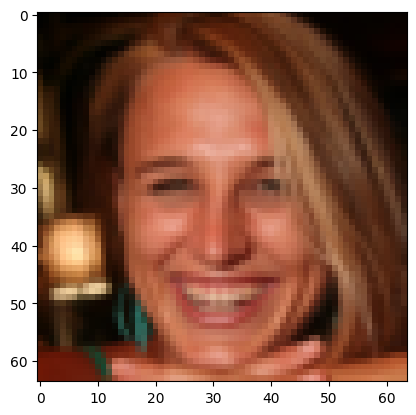

In [32]:
# For real
for i, labels in real_loader:
    image = i[0]
    print(image.shape)
    plt.imshow((image.permute(1, 2, 0) + 1)/2)
    label = labels[0]
    image = image[None,:,:,:]
    image = image.to(device)
    print("True label:", label.squeeze())
    print("Predicted label:", critic(image).squeeze())
    break

torch.Size([3, 64, 64])
True label: 0
Predicted label: tensor(0.0443, device='cuda:0', grad_fn=<SqueezeBackward0>)


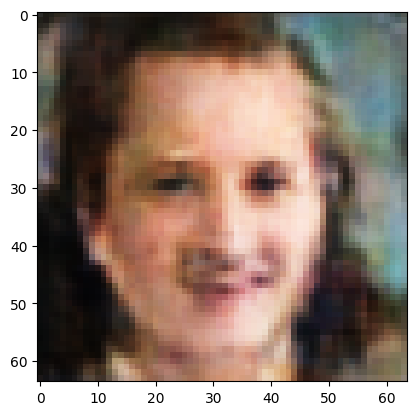

In [37]:
# For fake
for i, labels in fake_loader:
    image = gen(torch.randn(1, Z_DIM, 1, 1).to(device)).to(device)
    image = image[0]
    print(image.shape)
    plt.imshow((image.cpu().detach().permute(1, 2, 0) + 1)/2)
    label = 0
    image = image[None,:,:,:]
    image = image.to(device)
    print("True label:", label)
    print("Predicted label:", critic(image).squeeze())
    break